In [1]:
import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import tqdm
from transformers import get_linear_schedule_with_warmup

from UNet import UNet
from SimpleUNet import SimpleUNet

### Hyper-parameters

In [2]:
# training
batch_size = 128
eval_batch_size = 256
learning_rate = 2e-4
num_epochs = 10
num_warmup_stesp = 100

# diffusion model
diffusion_steps = 1000
beta_large = 0.02
beta_small = 1e-4

### Setup

In [3]:
train_loader = torch.utils.data.DataLoader(
      torchvision.datasets.MNIST('/tmp/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Pad(2)
                               # torchvision.transforms.Resize(32),
                             ])),
      batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
     torchvision.datasets.MNIST('/tmp/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                                torchvision.transforms.Pad(2)
                               # torchvision.transforms.Resize(32),
                             ])),
      batch_size=eval_batch_size, shuffle=True)

In [4]:
# model
model = UNet(
        input_channels=1,
        input_height=32,
        ch=32,
        ch_mult=(1, 2, 2, 2),
        num_res_blocks=1,
        attn_resolutions=(16,),
        resamp_with_conv=True,
        dropout=0.,
        )

# model = SimpleUNet(img_depth=1)

### Tests Model and DataLoader

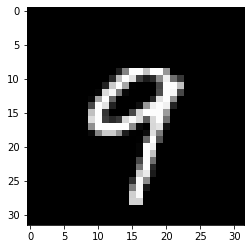

In [5]:
for batch in train_loader:
    break

img = batch[0][0].view(32,32)
fig = plt.figure
plt.imshow(img, cmap='gray')
plt.show()

In [6]:
x_ = torch.randn(1, 1, 32, 32)
t = torch.zeros(1)
output = model(x_, t)
output.shape

torch.Size([1, 1, 32, 32])

In [7]:
# number of parameters
sum(p.numel() for p in model.parameters()) // 1e6

1.0

### Training

In [8]:
def add_noise(imgs):
    z_noise = torch.randn_like(imgs)
    ts = torch.randint(0, diffusion_steps, (imgs.shape[0],), device=imgs.device)
    a_sampled = alpha_bars[ts].view(-1, 1, 1, 1)
    noised_imgs = torch.sqrt(a_sampled) * imgs + torch.sqrt(1 - a_sampled) * z_noise
    return noised_imgs, ts, z_noise

In [9]:
# coefficietns
betas = torch.Tensor([beta_small + (t / diffusion_steps) * (beta_large - beta_small) for t in range(diffusion_steps)])
alphas = 1 - betas
alpha_bars = torch.cumprod(alphas, 0)

In [10]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_stesp, num_training_steps=len(train_loader)*num_epochs)

In [11]:
# send to device
device = torch.device("cuda")
model = model.to(device)
betas = betas.to(device)
alphas = alphas.to(device)
alpha_bars = alpha_bars.to(device)

In [12]:
for epoch in range(num_epochs):
    
    model.train()
    pbar = tqdm.auto.tqdm(train_loader)
    moving_loss = 0.0
    for batch in pbar:
        imgs, labels = batch
        imgs = imgs.to(device)
        imgs = imgs * 2 - 1
        
        noised_imgs, ts, z_noise = add_noise(imgs)
        
        e_hat = model(noised_imgs, ts)
        
        loss = nn.functional.mse_loss(
            e_hat.reshape(imgs.shape[0], -1), z_noise.reshape(imgs.shape[0], -1)
        )
        
        moving_loss = moving_loss * 0.9 + 0.1 * loss.item()
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        pbar.set_postfix({'loss': moving_loss})
        
    with torch.no_grad():
        model.eval()
        with torch.random.fork_rng():
            torch.random.manual_seed(123)
            loss = 0
            for batch in tqdm.auto.tqdm(test_loader):
                imgs, labels = batch
                imgs = imgs.to(device)
                imgs = imgs * 2 - 1

                noised_imgs, ts, z_noise = add_noise(imgs)

                e_hat = model(noised_imgs, ts)

                loss += nn.functional.mse_loss(
                    e_hat.reshape(imgs.shape[0], -1), z_noise.reshape(imgs.shape[0], -1)
                )

            loss /= len(test_loader)
            print(f"Epoch {epoch} Validation loss: {loss}")

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 0 Validation loss: 0.02626449428498745


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1 Validation loss: 0.023728424683213234


  0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Sample Images

In [13]:
sample_steps = torch.arange(diffusion_steps - 1, -1, -1, device=device)

In [24]:
x = torch.randn(1, 1, 32, 32).to(device)

with torch.no_grad():
    for t in tqdm.auto.tqdm(sample_steps):
        # t = torch.zeros_like(t)
        z = model(x, t.unsqueeze(0))
        pre_scale = 1 / torch.sqrt(alphas[t])
        z_scale = (1 - alphas[t]) / torch.sqrt(1 - alpha_bars[t])
        sigma = torch.randn_like(x) * torch.sqrt(betas[t])
        x = pre_scale * (x - z * z_scale) + sigma

  0%|          | 0/1000 [00:00<?, ?it/s]

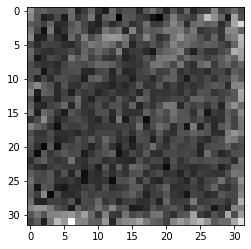

In [25]:
img = x[0][0].view(32,32).cpu().numpy()
fig = plt.figure
plt.imshow(img, cmap='gray')
plt.show()